In [1]:
# Autoreload packages in case they change.
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import btk

# "Custom" tutorial

This tutorial is intended to showcase how to customize some elements of BTK, namely the sampling function, the surveys or the measure function. We encourage you to follow the intro tutorial first if you have not already done so.

## Table of contents

- [Custom sampling function](#custom_sampling_function)
- [Custom survey](#custom_survey)
- [Custom measure function](#custom_measure_function)

## Custom sampling function

The sampling function defines how galaxies are selected in the catalog and their positions in the blends. This is done by defining a custom class based on the `SamplingFunction` class, which will be called (like a function) when the blends are generated. The `__call__` method should normally only take as an argument the catalog (as an astropy table), and return a smaller astropy table containing the entries from the catalog corresponding to the galaxies, along with the shifts (in arcseconds) of the galaxies compared to the center of the image, in the columns "ra" and "dec".
Here is an example with the default sampling function.

In [2]:
class DefaultSampling(btk.sampling_functions.SamplingFunction):
    """Default sampling function used for producing blend tables."""

    def __init__(self, max_number=2, stamp_size=24.0, maxshift=None):
        """
        Args:
            max_number (int): Defined in parent class
            stamp_size (float): Size of the desired stamp.
            maxshift (float): Magnitude of maximum value of shift. If None then it
                             is set as one-tenth the stamp size. (in arcseconds)
        """
        super().__init__(max_number)
        self.stamp_size = stamp_size
        self.maxshift = maxshift if maxshift else self.stamp_size / 10.0

    @property
    def compatible_catalogs(self):
        return "CatsimCatalog", "CosmosCatalog"

    def __call__(self, table, shifts=None, indexes=None):
        """Applies default sampling to the input CatSim-like catalog and returns an
        astropy table with entries corresponding to a blend centered close to postage
        stamp center.

        Function selects entries from input table that are brighter than 25.3 mag
        in the i band. Number of objects per blend is set at a random integer
        between 1 and Args.max_number. The blend table is then randomly sampled
        entries from the table after selection cuts. The centers are randomly
        distributed within 1/10th of the stamp size. Here even though the galaxies
        are sampled from a CatSim catalog, their spatial location are not
        representative of real blends.

        Args:
            table (astropy.table): Table containing entries corresponding to galaxies
                                   from which to sample.
            shifts (list): Contains arbitrary shifts to be applied instead of random ones.
                           Should of the form [x_peak,y_peak] where x_peak and y_peak are the lists
                           containing the x and y shifts.
            indexes (list): Contains the indexes of the galaxies to use.

        Returns:
            Astropy.table with entries corresponding to one blend.
        """
        number_of_objects = np.random.randint(1, self.max_number + 1)
        (q,) = np.where(table["ref_mag"] <= 25.3)

        if indexes is None:
            blend_table = table[np.random.choice(q, size=number_of_objects)]
        else:
            blend_table = table[indexes]
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        if shifts is None:
            x_peak, y_peak = _get_random_center_shift(number_of_objects, self.maxshift)
        else:
            x_peak, y_peak = shifts
        blend_table["ra"] += x_peak
        blend_table["dec"] += y_peak

        if np.any(blend_table["ra"] > self.stamp_size / 2.0) or np.any(
            blend_table["dec"] > self.stamp_size / 2.0
        ):
            warnings.warn("Object center lies outside the stamp")
        return blend_table
    

def _get_random_center_shift(num_objects, maxshift):
    """Returns random shifts in x and y coordinates between + and - max-shift in arcseconds.

    Args:
        num_objects (int): Number of x and y shifts to return.

    Returns:
        x_peak (float): random shift along the x axis
        y_peak (float): random shift along the x axis
    """
    x_peak = np.random.uniform(-maxshift, maxshift, size=num_objects)
    y_peak = np.random.uniform(-maxshift, maxshift, size=num_objects)
    return x_peak, y_peak

As you can see, this sampling function does 3 things: applying a magnitude cut to the catalog, selecting random galaxies uniformly (with a random number of galaxies, the maximum being specified at the initialization), and assigning them random uniform shifts.

Here is how we would write a sampling function for generating two galaxies, one bright and centered, the other faint and randomly shifted.

In [3]:
class PairSampling(btk.sampling_functions.SamplingFunction):
    
    def __init__(self, stamp_size=24.0, maxshift=None):
        super().__init__(2)
        self.stamp_size = stamp_size
        self.maxshift = maxshift if maxshift else self.stamp_size / 10.0

    @property
    def compatible_catalogs(self):
        return "CatsimCatalog", "CosmosCatalog"

    def __call__(self,table):
        number_of_objects = np.random.randint(1, self.max_number + 1)
        (q_bright,) = np.where(table["ref_mag"] <= 25.3)
        (q_dim,) = np.where((table["ref_mag"] > 25.3) & (table["ref_mag"] <= 28))
        
        indexes = [np.random.choice(q_bright),np.random.choice(q_dim)]
        blend_table = table[indexes]
        
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        
        x_peak, y_peak = _get_random_center_shift(1, self.maxshift)
        
        blend_table["ra"][1] += x_peak
        blend_table["dec"][1] += y_peak

        if np.any(blend_table["ra"] > self.stamp_size / 2.0) or np.any(
            blend_table["dec"] > self.stamp_size / 2.0
        ):
            warnings.warn("Object center lies outside the stamp")
        return blend_table

You can try to write your own sampling function here if you wish.

Here is some code to test our new sampling function (please replace the first line if you wrote your own sampling function).

In [4]:
sampling_function = PairSampling()
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
survey = btk.survey.get_surveys("Rubin")
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    stamp_size=stamp_size,
    batch_size=5
)

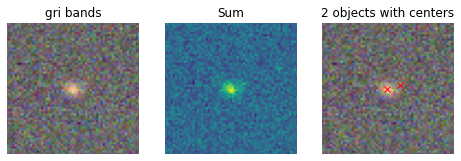

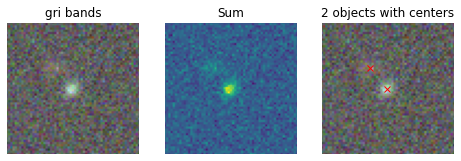

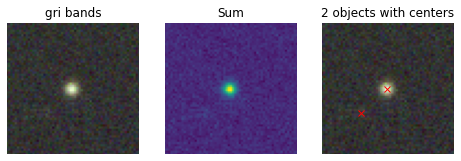

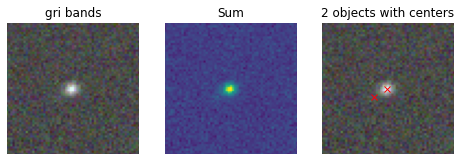

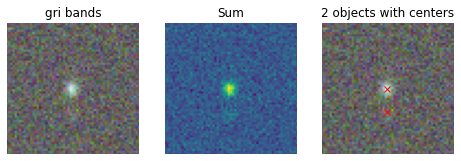

In [5]:
batch = next(draw_blend_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

<a id='custom_survey'></a>

## Custom survey
<a id='custom_survey'></a>
The survey defines the observational parameters relative to the instrument and telescope making the observation; in particular, it serves to define the pixel scale, the number of bands, the noise level, the flux, and the PSF.
A number of surveys is provided with BTK, so most users will not need to define a new one; however you may want to add one, or to modify one (for example to use a custom PSF). Here we will detail how to do so.

A Survey is defined as a named tuple, that is a tuple where each slot has a name. Here are all the fields that a survey contains:
- name: Name of the survey
- pixel_scale: Pixel scale in arcseconds
- effective_area: Light-collecting area of the telescope; depending on the optics of the telescope this can be different from $\pi*r^2$, in the case of a Schmidt–Cassegrain telescope for instance.
- mirror_diameter: Diameter of the primary telescope, in meters (without accounting for an eventual missing area)
- airmass: Length of the optical path through atmosphere, relative to the zenith path length. An airmass of 1.2 means that light would travel the equivalent of 1.2 atmosphere when observing. 
- zeropoint_airmass: airmass which was used when computing the zeropoints. If in doubt, set it to the same value as the airmass.
- filters: List of Filter objects, more on that below

The Filter object is, again, a named tuple, containing the informations relative to each filter; a single survey can contain multiple filters. Each filter contains:
- name: Name of the filter
- sky_brightness: brightness of the sky background, in mags/sq.arcsec
- exp_time: total exposure time, in seconds
- zeropoint: Magnitude of an object giving a measured flux of 1 electron per second
- extinction: exponential coefficient describing the absorption of light by the atmosphere.
- psf: PSF for the filter. This can be provided in two ways:
    - Providing a Galsim PSF model, e.g. `galsim.Kolmogorov(fwhm)` or any convolution of such models.
    - Providing a function which returns a Galsim model when called (with no arguments). This can be used when you 
      you want to randomize the PSF. More on that in the example below.
    In the case of the default surveys, we only use the first possibility, computing the model using the get_psf function beforehand; those models have an atmospheric and an optical component.

Surveys are usually imported using `btk.survey.get_surveys(survey_names)`, which will create the Survey object(s) from a config file (currently, the implemented surveys are Rubin, HSC, HST, Euclid, DES and CFHT); it is also possible to create them directly in Python.
Here is the definition of the Rubin survey as an example. You may try changing the parameters if you wish to see the effects on the blends.

In [6]:
from btk.survey import Survey, Filter, get_psf

_central_wavelength = {
    "u": 3592.13,
    "g": 4789.98,
    "r": 6199.52,
    "i": 7528.51,
    "z": 8689.83,
    "y": 9674.05,
}
Rubin = btk.survey.Survey(
    "Rubin",
    pixel_scale=0.2,
    effective_area=32.4,
    mirror_diameter=8.36,
    airmass=1.2,
    zeropoint_airmass=1.2,
    filters=[
        btk.survey.Filter(
            name="y",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["y"],
                fwhm=0.703,
            ),
            sky_brightness=18.6,
            exp_time=4800,
            zeropoint=26.56,
            extinction=0.138,
        ),
        btk.survey.Filter(
            name="z",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["z"],
                fwhm=0.725,
            ),
            sky_brightness=19.6,
            exp_time=4800,
            zeropoint=27.39,
            extinction=0.043,
        ),
        btk.survey.Filter(
            name="i",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["i"],
                fwhm=0.748,
            ),
            sky_brightness=20.5,
            exp_time=5520,
            zeropoint=27.78,
            extinction=0.07,
        ),
        btk.survey.Filter(
            name="r",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["r"],
                fwhm=0.781,
            ),
            sky_brightness=21.2,
            exp_time=5520,
            zeropoint=28.10,
            extinction=0.10,
        ),
        btk.survey.Filter(
            name="g",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["g"],
                fwhm=0.814,
            ),
            sky_brightness=22.3,
            exp_time=2400,
            zeropoint=28.26,
            extinction=0.163,
        ),
        btk.survey.Filter(
            name="u",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["u"],
                fwhm=0.859,
            ),
            sky_brightness=22.9,
            exp_time=1680,
            zeropoint=26.40,
            extinction=0.451,
        ),
    ],
)

In [7]:
sampling_function = btk.sampling_functions.DefaultSampling()
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
survey = Rubin
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    stamp_size=stamp_size,
    batch_size=5
)

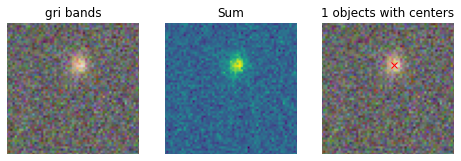

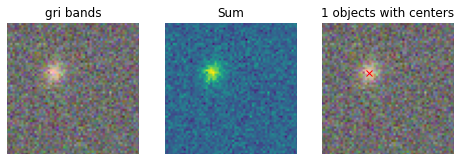

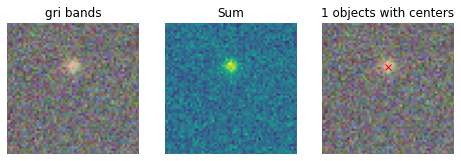

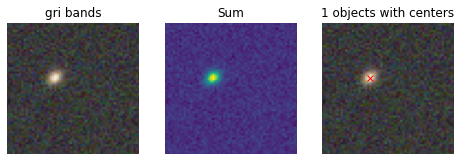

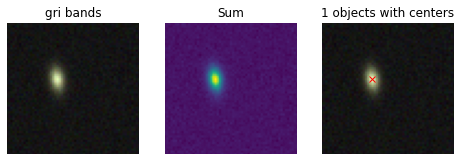

In [8]:
batch = next(draw_blend_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

## Custom measure function
<a id='custom_measure_function'></a>
Users who wish to test their own algorithm using BTK should consider writing a measure function. Morally, a measure function takes in blends and return measurements, ie detections, segmentation and deblended images. It is then fed to a MeasureGenerator, which will apply the function for every blend in the batch.
More precisely, the measure function takes in two main arguments, named `batch` and `idx`; the first one contains the whole results from the DrawBlendsGenerator, while the second contains the id of the blend on which the measurement should be carried. This is done so that the user access to every relevant information, including the PSF and WCS which are defined per batch and not per blend.
The results should be returned as a dictionary, with entries:
- "catalog" containing the detections, as an astropy Table object with columns "x_peak" and "y_peak" containing the coordinates of the detection. The user may also include other measurements in it, even though they will not be covered by the metrics.
- "segmentation" containing the measured segmentation. It should be a boolean array with shape (n_objects,stamp_size,stamp_size) where n_objects is the number of detected objects (must be coherent with the "catalog" object). The i-th channel should have pixels corresponding to the i-th object set to True.
- "deblended_images" containing the deblended images. It should be an array with shape (n_objects, n_bands, stamp_size, stamp_size) where n_objects is the number of detected objects and n_bands the number of bands. If you set the channels_last option to True, it should instead be of shape (n_objects, stamp_size, stamp_size, n_bands).

Here is an example with the sep measure function:

In [12]:
import sep
def sep_measure(batch, idx, channels_last=False, surveys=None, sigma_noise=1.5, **kwargs):
    """Return detection, segmentation and deblending information with SEP.

    NOTE: If this function is used with the multiresolution feature,
    measurements will be carried on the first survey, and deblended images
    or segmentations will not be returned.

    Args:
        batch (dict): Output of DrawBlendsGenerator object's `__next__` method.
        idx (int): Index number of blend scene in the batch to preform
            measurement on.
        sigma_noise (float): Sigma threshold for detection against noise.

    Returns:
        dict with the centers of sources detected by SEP detection algorithm.
    """
    channel_indx = 0 if not channels_last else -1

    # multiresolution
    if isinstance(batch["blend_images"], dict):
        if surveys is None:
            raise ValueError("surveys are required in order to use the MR feature.")
        survey_name = surveys[0].name
        image = batch["blend_images"][survey_name][idx]
        coadd = np.mean(image, axis=channel_indx)
        wcs = batch["wcs"][survey_name]

    # single-survey
    else:
        image = batch["blend_images"][idx]
        coadd = np.mean(image, axis=channel_indx)
        wcs = batch["wcs"]

    stamp_size = coadd.shape[0]
    bkg = sep.Background(coadd)
    catalog, segmentation = sep.extract(
        coadd, sigma_noise, err=bkg.globalrms, segmentation_map=True
    )

    n_objects = len(catalog)
    segmentation_exp = np.zeros((n_objects, stamp_size, stamp_size), dtype=bool)
    deblended_images = np.zeros((n_objects, *image.shape), dtype=image.dtype)
    for i in range(n_objects):
        seg_i = segmentation == i + 1
        segmentation_exp[i] = seg_i
        seg_i_reshaped = np.zeros((np.min(image.shape), stamp_size, stamp_size))
        for j in range(np.min(image.shape)):
            seg_i_reshaped[j] = seg_i
        seg_i_reshaped = np.moveaxis(seg_i_reshaped, 0, np.argmin(image.shape))
        deblended_images[i] = image * seg_i_reshaped

    t = astropy.table.Table()
    t["ra"], t["dec"] = wcs.pixel_to_world_values(catalog["x"], catalog["y"])

    # If multiresolution, return only the catalog
    if isinstance(batch["blend_images"], dict):
        return {"catalog": t}
    else:
        return {
            "catalog": t,
            "segmentation": segmentation_exp,
            "deblended_images": deblended_images,
        }

You can see that the function takes `batch` and `idx` as arguments, but also has a `channels_last` argument and some kwargs. You can either specify arguments or catch them with `kwargs.get()`, as is done with `sigma_noise` there. To pass those arguments to the function, you can use the measure_kwargs, as detailed later in this tutorial. The `channels_last` (specifying if the channels are the first or last dimension of the image) and the `survey` (BTK survey object) are always passed to the function (you can choose if you want to catch them with `kwargs.get()` or not).

In the multiresolution case, the segmentation and the deblended images should be dictionaries indexed by the surveys, each entry containing the results as for the single resolution case. The catalog field does not change, as the ra and dec are independent from the resolution; it will be automatically split in the MeasureGenerator to get several catalogs containing the pixel coordinates.